Tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading MNIST

In [4]:
transforms = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])

In [5]:
mnist = torchvision.datasets.MNIST('./MNIST/MNIST_train/', train=True, download=True, transform=transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST_train/MNIST/raw



In [6]:
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 - 8 - 3 - 6 - 7 - 6 - 2 - 6 - 9 - 0 - 8 - 2 - 6 - 1 - 2 - 8 - 9 - 1 - 7 - 6 - 8 - 3 - 2 - 9 - 2 - 4 - 7 - 5 - 8 - 5 - 6 - 5 - 7 - 4 - 2 - 2 - 7 - 1 - 1 - 7 - 3 - 9 - 1 - 3 - 1 - 9 - 7 - 6 - 4 - 4 - 7 - 6 - 5 - 2 - 8 - 2 - 1 - 2 - 4 - 3 - 8 - 6 - 3 - 0 - 9 - 9 - 4 - 7 - 3 - 8 - 6 - 4 - 5 - 1 - 2 - 2 - 1 - 5 - 2 - 5 - 8 - 8 - 7 - 4 - 7 - 1 - 5 - 0 - 9 - 6 - 9 - 9 - 3 - 7 - 9 - 2 - 2 - 2 - 8 - 0 - 1 - 8 - 2 - 7 - 4 - 7 - 9 - 5 - 5 - 6 - 0 - 5 - 1 - 0 - 5 - 3 - 6 - 2 - 1 - 5 - 3 - 7 - 5 - 7 - 6 - 3 - 0 - 5


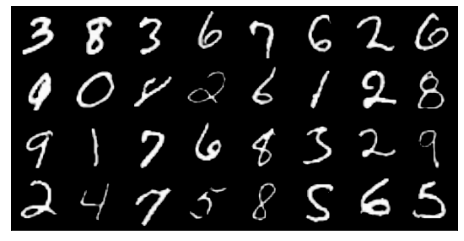

In [7]:
batch_X, batch_Y = iter(data_loader).next()

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
img_grid = make_grid((batch_X[:32]), nrow=8)
ax.imshow(img_grid.permute(1, 2, 0))

print(" - ".join(map(lambda x: str(x.item()), batch_Y)))

## Models

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [43]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=nz,
                out_channels=ngf * 8, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
            ),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [44]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [46]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Training

In [47]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training Loop:
1. Get mini batch from dataloader
2. Feed it to discriminator and calculate loss with target = 1
3. Generate noise vector
4. Feed it to generator
5. Feed detached generator output to discriminator and calculate loss with target = 0
5. Backprop with both losses combined
6. Feed generator output to discriminator again (since we have updated it)
7. Calculate loss on discriminator output with target = 1
8. Backprop with this loss to update generator

In [48]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))

        netG.zero_grad()
        
        label.fill_(real_label)
        
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/469]	Loss_D: 1.5838	Loss_G: 2.6061	D(x): 0.3998	D(G(z)): 0.3359 / 0.0993
[0/5][50/469]	Loss_D: 0.0233	Loss_G: 9.6695	D(x): 0.9806	D(G(z)): 0.0002 / 0.0001
[0/5][100/469]	Loss_D: 0.0455	Loss_G: 3.1799	D(x): 0.9894	D(G(z)): 0.0316 / 0.1071
[0/5][150/469]	Loss_D: 0.0999	Loss_G: 4.7655	D(x): 0.9630	D(G(z)): 0.0575 / 0.0108
[0/5][200/469]	Loss_D: 0.1391	Loss_G: 4.7136	D(x): 0.9373	D(G(z)): 0.0521 / 0.0116
[0/5][250/469]	Loss_D: 0.2314	Loss_G: 4.3212	D(x): 0.9339	D(G(z)): 0.1329 / 0.0192
[0/5][300/469]	Loss_D: 0.2981	Loss_G: 2.5259	D(x): 0.7988	D(G(z)): 0.0431 / 0.1236
[0/5][350/469]	Loss_D: 0.7449	Loss_G: 2.0878	D(x): 0.9147	D(G(z)): 0.4136 / 0.1700
[0/5][400/469]	Loss_D: 0.2117	Loss_G: 3.2813	D(x): 0.9061	D(G(z)): 0.0957 / 0.0529
[0/5][450/469]	Loss_D: 0.5491	Loss_G: 2.0692	D(x): 0.6619	D(G(z)): 0.0097 / 0.1829
[1/5][0/469]	Loss_D: 0.3948	Loss_G: 2.4440	D(x): 0.8417	D(G(z)): 0.1763 / 0.1148
[1/5][50/469]	Loss_D: 0.2390	Loss_G: 2.9158	D(x): 0.8816	D(G(z)): 0.0954 / 0.0742
[1/5][100/

## Evaluation

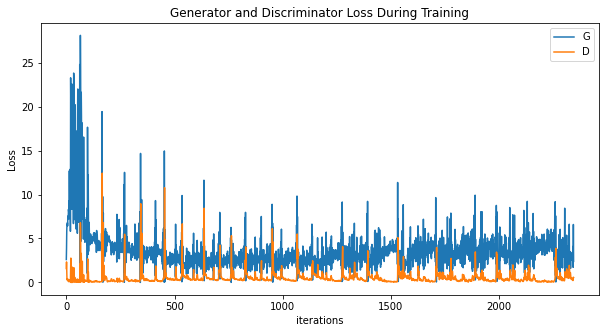

In [49]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

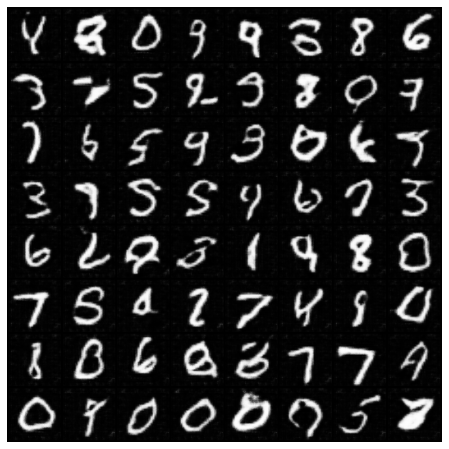

In [55]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())